1. 数据读取和预处理，得到 Dataset 和 DataLoader
2. 构建 Model、Optimizer
3. 使用随机梯度下降迭代优化模型参数
4. 设置 Metric，对模型进行评测

# 导包

In [1]:
import numpy as np 
import pandas as pd 
import torch
import random
import pickle
from tqdm import tqdm
from collections import Counter
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F

# 数据读取与预处理

In [2]:
train = pd.read_csv('./data/train.tsv',sep='\t')
test = pd.read_csv('./data/test.tsv',sep='\t')

In [3]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [13]:
corpus = []
corpus.append(train.Phrase[1].lower().split())
corpus.append(train.Phrase[2].lower().split())
print(corpus)
corpus = Counter(np.hstack(corpus))
corpus = corpus
print(corpus)
corpus2 = sorted(corpus,key=corpus.get,reverse=True)
print(corpus2)
vocab_to_int = {word: idx for idx,word in enumerate(corpus2,1)}
vocab_to_int

[['a', 'series', 'of', 'escapades', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose'], ['a', 'series']]
Counter({'a': 2, 'series': 2, 'the': 2, 'of': 1, 'escapades': 1, 'demonstrating': 1, 'adage': 1, 'that': 1, 'what': 1, 'is': 1, 'good': 1, 'for': 1, 'goose': 1})
['a', 'series', 'the', 'of', 'escapades', 'demonstrating', 'adage', 'that', 'what', 'is', 'good', 'for', 'goose']


{'a': 1,
 'series': 2,
 'the': 3,
 'of': 4,
 'escapades': 5,
 'demonstrating': 6,
 'adage': 7,
 'that': 8,
 'what': 9,
 'is': 10,
 'good': 11,
 'for': 12,
 'goose': 13}

In [ ]:
# 定义函数Corpus_Extr，用于构建语料库
def Corpus_Extr(df):

    print('Construct Corpus...') # 正在构建语料库

    # 创建一个空列表，用于存放文本语料库中的单词
    corpus = []
    # 遍历训练数据集中的每一行
    for i in tqdm(range(len(df))):
        # 将每一行数据的短语（Phrase）转换为小写，并以空格分割成单词列表，将单词存入corpus列表中
        corpus.append(df.Phrase[i].lower().split())
        
    # 将corpus列表中的元素转换为计数器，并将其存入corpus中
    corpus = Counter(np.hstack(corpus))
    corpus = corpus
    # 将corpus中的元素按照计数器中的值进行排序，并将排序后的元素存入corpus2中
    corpus2 = sorted(corpus,key=corpus.get,reverse=True) # True从大到小 False从小到大
    
    print('Convert Corpus to Integers') # 正在将语料库转换为整数
    
    # 创建映射字典vocab_to_int，将单词映射到整数
    vocab_to_int = {word: idx for idx,word in enumerate(corpus2,1)}
  
    print('Convert Phrase to Integers') # 正在将文本数据转换为整数
    
    # 创建一个空列表，用于存放转换后的短语
    phrase_to_int = []
    # 遍历训练数据集，将每一行数据的短语转换为小写，并以空格分割，将每一个短语中的每一个单词，按照vocab_to_int中的值进行转换，存入phrase_to_int列表中
    for i in tqdm(range(len(df))):
        phrase_to_int.append([vocab_to_int[word] for word in df.Phrase.values[i].lower().split()])
    # 返回corpus、vocab_to_int、phrase_to_int
    return corpus,vocab_to_int,phrase_to_int
# 调用函数Corpus_Extr，将训练数据集转换为语料库
corpus,vocab_to_int,phrase_to_int = Corpus_Extr(train)
    

Construct Corpus...


100%|██████████| 156060/156060 [00:01<00:00, 110191.24it/s]


Convert Corpus to Integers
Convert Phrase to Integers


100%|██████████| 156060/156060 [00:01<00:00, 133092.57it/s]


#### 代码详解
1. `corpus = Counter(np.hstack(corpus))`

`np.hstack()`函数用于将两个或多个数组连接成一个数组，这里将`corpus`列表中的所有单词连接成一个数组，然后使用`Counter()`函数计算每个单词的计数。

`Counter()`函数用于计算序列中元素的频率。它接受一个可迭代对象（如列表、元组等）作为参数，并返回一个字典，其中键是序列中的元素，值是对应的元素出现的次数。

例如，如果`corpus`列表中包含以下单词：
```
['apple', 'banana', 'apple', 'orange', 'banana', 'apple']
```
则`corpus`列表中的单词计数将如下所示：
```
Counter({'apple': 3, 'banana': 2, 'orange': 1})
```
其中，`'apple'`出现了3次，`'banana'`和`'orange'`各出现了2次。

-----

2. `vocab_to_int = {word: idx for idx,word in enumerate(corpus2,1)}`

创建了一个字典vocab_to_int，用于将corpus2中的单词映射到整数索引。

  -  `{}`：这是字典的创建方法，表示创建一个空字典。

  -  `word: idx`：这是字典的键值对，其中word是键，idx是值。

  -  `for idx, word in enumerate(corpus2, 1)`：这是一个for循环，用于迭代corpus2中的元素。enumerate函数将corpus2中的每个元素与它的索引配对。idx是索引，word是corpus2中的元素。

  -  `enumerate(corpus2, 1)`：enumerate函数用于返回一个枚举对象，它生成一个包含索引和值的元组。参数1指定开始索引的值，这里设置为1。

  -  `word: idx for idx, word in enumerate(corpus2, 1)`：这是一个字典推导式，它使用enumerate函数生成的元组创建字典的键值对。

代码行`vocab_to_int = {word: idx for idx,word in enumerate(corpus2,1)}`将corpus2中的单词作为键，索引作为值，创建了一个映射字典vocab_to_int。索引的起始值为1。 这个字典可以在后续代码中用来将单词转换为整数索引。

In [4]:
def Pad_sequences(phrase_to_int,seq_length):
    pad_sequences = np.zeros((len(phrase_to_int), seq_length),dtype=int)
    for idx,row in tqdm(enumerate(phrase_to_int),total=len(phrase_to_int)):
        pad_sequences[idx, :len(row)] = np.array(row)[:seq_length]
    return pad_sequences

In [5]:
pad_sequences = Pad_sequences(phrase_to_int,30)

100%|██████████| 156060/156060 [00:00<00:00, 493735.99it/s]


In [6]:
train.sample(50)

,PhraseId,SentenceId,Phrase,Sentiment
26050,26051,1191,a laugh,3
41407,41408,1990,liked it much more if Harry & Tonto never existed,1
21,22,1,good for the goose,3
68935,68936,3501,see on,2
134874,134875,7279,even with that radioactive hair,2
79769,79770,4108,sexual innuendoes,2
129250,129251,6951,"Some of the characters die and others do n't ,...",0
100038,100039,5249,"dramatic punch , a haunting ode to humanity",2
75268,75269,3862,"It has fun with the quirks of family life ,",3
105842,105843,5586,Safe Conduct -LRB- Laissez Passer -RRB-,2


In [7]:
class PhraseDataset(Dataset):
    def __init__(self,df,pad_sequences):
        super().__init__()
        self.df = df
        self.pad_sequences = pad_sequences
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        if 'Sentiment' in self.df.columns:
            label = self.df['Sentiment'].values[idx]
            item = self.pad_sequences[idx]
            return item,label
        else:
            item = self.pad_sequences[idx]
            return item

In [8]:
class SentimentRNN(nn.Module):
    
    def __init__(self,corpus_size,output_size,embedd_dim,hidden_dim,n_layers):
        super().__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(corpus_size,embedd_dim)
        self.lstm = nn.LSTM(embedd_dim, hidden_dim,n_layers,dropout=0.5, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim,output_size)
        self.act = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds,hidden)
        lstm_out = lstm_out.contiguous().view(-1,self.hidden_dim)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.act(out)
        out = out.view(batch_size,-1)
        out = out[:,-5:]
        return out, hidden
    def init_hidden(self,batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                   weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        return hidden

In [9]:
vocab_size = len(vocab_to_int)
output_size = 5
embedding_dim = 400
hidden_dim = 256
n_layers = 2
net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim,n_layers)

In [10]:
net.train()
clip=5
epochs = 200
counter = 0
print_every = 100
lr=0.01

def criterion(input, target, size_average=True):
    """Categorical cross-entropy with logits input and one-hot target"""
    l = -(target * torch.log(F.softmax(input, dim=1) + 1e-10)).sum(1)
    if size_average:
        l = l.mean()
    else:
        l = l.sum()
    return l
#criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [11]:
import gc

In [12]:
batch_size=32
losses = []
accs=[]
for e in range(epochs):
    a = np.random.choice(len(train)-1, 1000)
    train_set = PhraseDataset(train.loc[train.index.isin(np.sort(a))],pad_sequences[a])
    train_loader = DataLoader(train_set,batch_size=32,shuffle=True)
    # initialize hidden state
    h = net.init_hidden(32)
    running_loss = 0.0
    running_acc = 0.0
    # batch loop
    for idx,(inputs, labels) in enumerate(train_loader):
        counter += 1
        gc.collect()
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        optimizer.zero_grad()
        if inputs.shape[0] != batch_size:
            break
        # get the output from the model
        output, h = net(inputs, h)
        labels=torch.nn.functional.one_hot(labels, num_classes=5)
        # calculate the loss and perform backprop
        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.cpu().detach().numpy()
        running_acc += (output.argmax(dim=1) == labels.argmax(dim=1)).float().mean()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()
        if idx%20 == 0:
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format((running_loss/(idx+1))))
            losses.append(float(running_loss/(idx+1)))
            print(f'acc:{running_acc/(idx+1)}')
            accs.append(running_acc/(idx+1))

Epoch: 1/200... Step: 1... Loss: 1.608367...
acc:0.125
Epoch: 1/200... Step: 21... Loss: 1.380012...
acc:0.511904776096344
Epoch: 2/200... Step: 33... Loss: 1.439609...
acc:0.375
Epoch: 2/200... Step: 53... Loss: 1.374001...
acc:0.5089285969734192
Epoch: 3/200... Step: 65... Loss: 1.553238...
acc:0.3125
Epoch: 3/200... Step: 85... Loss: 1.386855...
acc:0.5029761791229248
Epoch: 4/200... Step: 97... Loss: 1.481799...
acc:0.40625
Epoch: 4/200... Step: 117... Loss: 1.389517...
acc:0.507440447807312
Epoch: 5/200... Step: 129... Loss: 1.296151...
acc:0.59375
Epoch: 5/200... Step: 149... Loss: 1.390219...
acc:0.5029761791229248
Epoch: 6/200... Step: 161... Loss: 1.438620...
acc:0.40625
Epoch: 6/200... Step: 181... Loss: 1.392731...
acc:0.4970238208770752
Epoch: 7/200... Step: 193... Loss: 1.354515...
acc:0.53125
Epoch: 7/200... Step: 213... Loss: 1.369962...
acc:0.523809552192688
Epoch: 8/200... Step: 225... Loss: 1.321947...
acc:0.5625
Epoch: 8/200... Step: 245... Loss: 1.352301...
acc:0.53

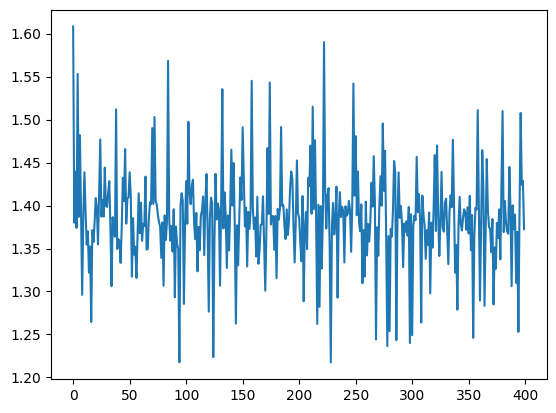

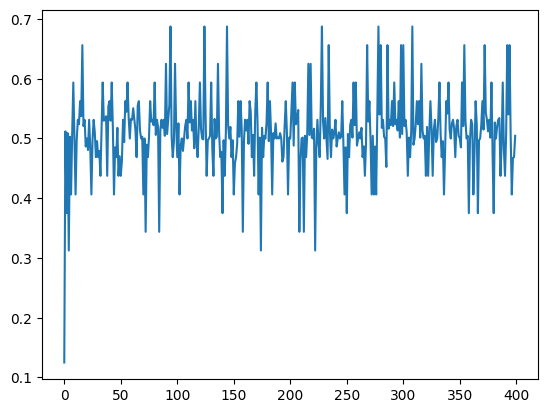

In [13]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()
plt.plot(accs)
plt.show()